In [23]:
import numpy as np
from numpy.linalg import inv
from scipy import stats
from scipy.linalg import sqrtm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
#IMPORT THE fun.py

#Simulate series using coefficients estimated with nowcasted daily data


In [24]:
period_display = 6
T = 6190 + 66
K = 3
Bhat_estimated = np.load("Bhat.npy")
Bhat_d_dict = {}

Ad = Bhat_estimated[:,:K]
Aw = Bhat_estimated[:,K:K*2]
Am = Bhat_estimated[:,K*2:K*3]
Aq = Bhat_estimated[:,K*3:]

Ad[0,0] = 1
Ad[1,1] = 1

u0=np.random.normal(0, 1, T)
u1=np.random.normal(0, 1, T)
u2=np.random.normal(0, 1, T)
u=np.array([u0,u1,u2]).T

w = np.zeros(K)
w0 = np.zeros(K)
w1 = np.zeros(K)

y_d_l = np.zeros((T,K))
y_d_l[:66,:]=np.array([np.random.uniform(-1,1),
            np.random.uniform(-1,1),
            np.random.uniform(-1,1)]).T

y_d_l = np.zeros((T,K))
for t in range(66,T):
    for j in range(K):
        w0[j] = np.mean(y_d_l[t-5:t-1,j])
        w1[j] = np.mean(y_d_l[t-22:t-5,j])
        w[j] = np.mean(y_d_l[t-66:t-22,j])
    y_d_l[t,:] = np.dot(Ad,y_d_l[t-1,:]) + np.dot(Aw,y_d_l[t-5,:]) + np.dot(Am,y_d_l[t-22,:]) + np.dot(Aq,y_d_l[t-66,:]) + u[t,:]
y_d_l = y_d_l[66:,:]

#Estimate the HF-VAR

In [25]:
shock = 0 #Select the variable to shock

inc=0
Q2 = 0
Q3=0
Q4=0
Q5=0
Q6 = 0
Q7 = 0
Q8 = 0
Q9 = 0
Q10 = 0
Q11 = 0
Q12 = 0
Bhat_dh,Bhat_d2,Bhat_d3,Bhat_d4,Bhat_d5,Bhat_d6,Bhat_d7,Bhat_d8,Bhat_d9,Bhat_d10,Bhat_d11,Bhat_d12, Sigmahat_dh, Uhat_dh ,_ ,_ ,Zhet ,_ ,_ = HVARls1(y_d_l,1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12)

#HF-SVAR identification

In [26]:
Bhat_d_dict[0] = Bhat_dh


B_hat_orig = Bhat_dh.copy()

d=66
Y=y_d_l
level = 1
het = 1
T = y_d_l.shape[0]
p_d = 1

W_d = 4
M_d = 21
Q_d = 65
Q_d2 = 131

Bhat_d = Bhat_dh


for i in range(W_d):
    if i == 0:
        Bhet_0 = Bhat_d[:,K:2*K]
    else:
        Bhet_0 = np.hstack((Bhet_0, Bhat_d[:,K:2*K]))

for i in range(M_d-W_d):
    if i == 0:
        Bhet_1 = Bhat_d[:,2*K:3*K]
    else:
        Bhet_1 = np.hstack((Bhet_1,Bhat_d[:,2*K:3*K]))

for i in range(Q_d-M_d):
    if i == 0:
        Bhet_2 = Bhat_d[:,3*K:4*K]
    else:
        Bhet_2 = np.hstack((Bhet_2,Bhat_d[:,3*K:4*K]))



B = np.hstack(( np.hstack((Bhet_0,Bhet_1)), Bhet_2))
Bhat_d = np.hstack((Bhat_d[:,:K],B))
Bhat_d_b = Bhat_d
y_d_l1 = y_d_l

Z_het = np.zeros((K*66*p_d, T - 66*1))
U = np.zeros(66*p_d*K)
chol1 = np.linalg.cholesky(Sigmahat_dh)
U[shock] = 1/chol1[shock,shock]
U[:K] = np.dot(np.linalg.cholesky(Sigmahat_dh), U[:K])
p = 66*p_d
Z_het[:,0] =  U

y_d_l = np.zeros((T,K))
y_d_l[66*p_d-1,:] = U[:K]

for t in range(p, y_d_l.shape[0]-1):
    y_d_l[t,:] = np.dot(Bhat_d,Z_het[:,t-p])
    Z_het[:,t-p+1] = np.reshape(y_d_l[t-66*p_d+1:t+1,:][::-1], (K*66*p_d))

y_d_l = y_d_l.T[:,p-1:]

irf = y_d_l[:,:66*period_display]

#Bootstrap C.I. for HF-SVAR





In [27]:
%%capture test

Bs = 100 #Number of bootstrap replication
period_display1 = period_display*66
variable0 = np.zeros((Bs,period_display1))
variable1 = np.zeros((Bs,period_display1))
variable2 = np.zeros((Bs,period_display1))
variable3 = np.zeros((Bs,period_display1))


U_bar = np.zeros(K)
U_std = np.zeros(K)
U_s = np.zeros((Uhat_dh.shape))
for k in range(K):
    U_bar[k]=(np.mean(Uhat_dh[k,:]))
    U_std[k]=(np.std(Uhat_dh[k,:]))
for i in range(Uhat_dh.shape[1]):
    U_s[:,i]=(Uhat_dh[:,i].T - U_bar)

Ym = {}
Yq = {}
Yd = {}
for b in range(Bs):
    print(b)
    T = 6190 + 66


    u0=np.random.normal(0, 1, T)
    u1=np.random.normal(0, 1, T)
    u2=np.random.normal(0, 1, T)
    u=np.array([u0,u1,u2]).T

    w = np.zeros(K)
    w0 = np.zeros(K)
    w1 = np.zeros(K)

    y_d_l_b = np.zeros((T,K))
    y_d_l_b[:66,:]=np.array([np.random.uniform(-1,1),
                np.random.uniform(-1,1),
                np.random.uniform(-1,1)]).T

    for t in range(66,T):
        for j in range(K):
            w0[j] = np.mean(y_d_l_b[t-5:t-1,j])
            w1[j] = np.mean(y_d_l_b[t-22:t-5,j])
            w[j] = np.mean(y_d_l_b[t-66:t-22,j])
        y_d_l_b[t,:] = np.dot(Ad,y_d_l_b[t-1,:]) + np.dot(Aw,y_d_l_b[t-5,:]) + np.dot(Am,y_d_l_b[t-22,:]) + np.dot(Aq,y_d_l_b[t-66,:]) + u[t,:]

    y_d_l_b = y_d_l_b[66:,:]

    Yd[b] = y_d_l_b
    Ym[b] = y_d_l_b[::22]
    Yq[b] = y_d_l_b[::66]


    Bhat_dh,Bhat_d2,Bhat_d3,Bhat_d4,Bhat_d5,Bhat_d6,Bhat_d7,Bhat_d8,Bhat_d9,Bhat_d10,Bhat_d11,Bhat_d12, Sigmahat_dh, Uhat_dh ,_ ,_ ,Zhet ,_ ,_ = HVARls1(y_d_l_b,1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12)


    Bhat_d_dict[b] = Bhat_dh


    #Daily VAR identification:
    W_d = 4
    M_d = 21
    Q_d = 65
    Q_d2 = 131

    Bhat_d = Bhat_dh




    for i in range(W_d):
        if i == 0:
            Bhet_0 = Bhat_d[:,K:2*K]
        else:
            Bhet_0 = np.hstack((Bhet_0, Bhat_d[:,K:2*K]))

    for i in range(M_d-W_d):
        if i == 0:
            Bhet_1 = Bhat_d[:,2*K:3*K]
        else:
            Bhet_1 = np.hstack((Bhet_1,Bhat_d[:,2*K:3*K]))

    for i in range(Q_d-M_d):
        if i == 0:
            Bhet_2 = Bhat_d[:,3*K:4*K]
        else:
            Bhet_2 = np.hstack((Bhet_2,Bhat_d[:,3*K:4*K]))


    B = np.hstack(( np.hstack((Bhet_0,Bhet_1)), Bhet_2))

    Bhat_d = np.hstack((Bhat_d[:,:K],B))


    Z_het = np.zeros((K*66*p_d, T - 66*1))
    U = np.zeros(66*p_d*K)
    chol1 = np.linalg.cholesky(Sigmahat_dh)
    U[shock] = 1/chol1[shock,shock]
    U[:K] = np.dot(np.linalg.cholesky(Sigmahat_dh), U[:K])
    p = 66*p_d
    Z_het[:,0] =  U

    y_d_l = np.zeros((T,K))
    y_d_l[66*p_d-1,:] = U[:K]



    for t in range(p, y_d_l.shape[0]-1):
        y_d_l[t,:] = np.dot(Bhat_d,Z_het[:,t-p])
        Z_het[:,t-p+1] = np.reshape(y_d_l[t-66*p_d+1:t+1,:][::-1], (K*66*p_d))


    y_d_l = y_d_l.T


    y_d_l = y_d_l[:,p-1:]

    irf_b = y_d_l[:,:66*period_display].T

    variable0[b,:] = irf_b[:,0]
    variable1[b,:] = irf_b[:,1]
    variable2[b,:] = irf_b[:,2]


low0 = np.zeros(period_display1)
up0 = np.zeros(period_display1)

low1 = np.zeros(period_display1)
up1 = np.zeros(period_display1)

low2 = np.zeros(period_display1)
up2 = np.zeros(period_display1)



variable0 = np.vstack((irf[0,:], variable0))
variable1 = np.vstack((irf[1,:], variable1))
variable2 = np.vstack((irf[2,:], variable2))


ci_l = 10
ci_u = 100 - ci_l
for t in range(period_display1):
    irf[0,t] = np.mean(variable0[:,t])
    low0[t] = np.percentile(variable0[:,t], ci_l)
    up0[t] = np.percentile(variable0[:,t], ci_u)
    irf[1,t] = np.mean(variable1[:,t])
    low1[t] = np.percentile(variable1[:,t], ci_l)
    up1[t] = np.percentile(variable1[:,t], ci_u)
    irf[2,t] = np.mean(variable2[:,t])
    low2[t] = np.percentile(variable2[:,t], ci_l)
    up2[t] = np.percentile(variable2[:,t], ci_u)




irf0_d =irf[0,:]
up0_d =up0
low0_d =low0

irf1_d =irf[1,:]
up1_d =up1
low1_d =low1

irf2_d =irf[2,:]
up2_d =up2
low2_d =low2



#LF estimation and bootstrap

In [28]:
%%capture test

u0=np.random.normal(0, 1, T)
u1=np.random.normal(0, 1, T)
u2=np.random.normal(0, 1, T)
u=np.array([u0,u1,u2]).T

w = np.zeros(K)
w0 = np.zeros(K)
w1 = np.zeros(K)

y_d_l_b = np.zeros((T,K))
y_d_l_b[:66,:]=np.array([np.random.uniform(-1,1),
            np.random.uniform(-1,1),
            np.random.uniform(-1,1)]).T

for t in range(66,T):
    for j in range(K):
        w0[j] = np.mean(y_d_l_b[t-5:t-1,j])
        w1[j] = np.mean(y_d_l_b[t-22:t-5,j])
        w[j] = np.mean(y_d_l_b[t-66:t-22,j])
    y_d_l_b[t,:] = np.dot(Ad,y_d_l_b[t-1,:]) + np.dot(Aw,w0) + np.dot(Am,w1) +  np.dot(Aq,w) + u[t,:]

y_d_l_b = y_d_l_b[66:,:]
y_m_l = y_d_l_b[::22]

M = y_m_l.shape[0]


y_m_l1 = y_m_l

p=3

Bm,sigma1,Uhat_m,_,_,Zm,_,_ = VARls(y_m_l1,p,0)
y_m_l = np.zeros((M,K))

Traw = M


Y=y_m_l[p:,:].T
a=np.empty((1,K,))
a[:]=np.NaN
rhs=[]
r=y_m_l
for i in range(p):
    r=np.vstack((a,r))
    h=np.delete(r,np.s_[Traw:],0)
    if i>0:
        rhs=np.hstack((rhs,h))
    else:
        rhs=h
Z=rhs[p:,:].T
U = np.zeros(K*p)
chol2 = np.linalg.cholesky(sigma1)
U[shock] = 1/chol2[shock,shock]
U[:K] = np.dot(chol2, U[:K])
Z[:,0] = U
y_m_l[p-1,:] = U[:K]

for t in range(p,y_m_l.shape[0]-1):
    y_m_l[t,:] = np.dot(Bm,Z[:,t-p])
    Z[:,t-p+1] = np.reshape( np.vstack((y_m_l[t,:], y_m_l[t-p+1:t,:][::-1] )), (K*p))

y_m_l = y_m_l.T
y_m_l = y_m_l[:,p-1:]

irf = y_m_l[:,:(period_display*3)]
irf.shape

period_display1 = (period_display)*3
variable0 = np.zeros((Bs,period_display1))
variable1 = np.zeros((Bs,period_display1))
variable2 = np.zeros((Bs,period_display1))
variable3 = np.zeros((Bs,period_display1))





for b in range(Bs):
    print(b)

    y_m_l_b = Ym[b]

    M = y_m_l_b.shape[0]

    Bm_b,sigma1b,_,_,_,_,_,_ = VARls(y_m_l_b,p,0)
    y_q_l = np.zeros((M,K))

    Traw = M


    Y=y_m_l_b[p:,:].T
    a=np.empty((1,K,))
    a[:]=np.NaN
    rhs=[]
    r=y_q_l
    for i in range(p):
        r=np.vstack((a,r))
        h=np.delete(r,np.s_[Traw:],0)
        if i>0:
            rhs=np.hstack((rhs,h))
        else:
            rhs=h
    Z=rhs[p:,:].T
    U = np.zeros(K*p)
    chol2 = np.linalg.cholesky(sigma1b)
    U[shock] = 1/chol2[shock,shock]
    U[:K] = np.dot(chol2, U[:K])
    Z[:,0] = U
    y_q_l[p-1,:] = U[:K]

    for t in range(p,y_q_l.shape[0]-1):
        y_q_l[t,:] = np.dot(Bm_b,Z[:,t-p])
        Z[:,t-p+1] = np.reshape(np.vstack((y_q_l[t,:], y_q_l[t-p+1:t,:][::-1] )), (K*p))



    y_q_l = y_q_l.T
    y_q_l = y_q_l[:,p-1:]

    irf_b = y_q_l[:,:(period_display*3)]

    variable0[b,:] = irf_b[0,:]
    variable1[b,:] = irf_b[1,:]
    variable2[b,:] = irf_b[2,:]




low0 = np.zeros(period_display1)
up0 = np.zeros(period_display1)

low1 = np.zeros(period_display1)
up1 = np.zeros(period_display1)

low2 = np.zeros(period_display1)
up2 = np.zeros(period_display1)

low3 = np.zeros(period_display1)
up3 = np.zeros(period_display1)

variable0 = np.vstack((irf[0,:], variable0))
variable1 = np.vstack((irf[1,:], variable1))
variable2 = np.vstack((irf[2,:], variable2))

ci_l = 10
ci_u = 100 - ci_l
for t in range(period_display1):
    irf[0,t] = np.mean(variable0[:,t])
    low0[t] = np.percentile(variable0[:,t], ci_l)
    up0[t] = np.percentile(variable0[:,t], ci_u)
    irf[1,t] = np.mean(variable1[:,t])
    low1[t] = np.percentile(variable1[:,t], ci_l)
    up1[t] = np.percentile(variable1[:,t], ci_u)
    irf[2,t] = np.mean(variable2[:,t])
    low2[t] = np.percentile(variable2[:,t], ci_l)
    up2[t] = np.percentile(variable2[:,t], ci_u)




irf0_m =irf[0,:]
up0_m =up0
low0_m =low0

irf1_m =irf[1,:]
up1_m =up1
low1_m =low1

irf2_m =irf[2,:]
up2_m =up2
low2_m =low2





xs = np.arange(irf1_d.shape[0])


N = 21

out = np.zeros(irf1_m.size * (N+1) - N , irf1_m.dtype)
out[::N+1] = irf1_m

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

temp_aggr = 264 + 66


irf1_m = out[:temp_aggr]
irf1_d = irf1_d[:temp_aggr]


out = np.zeros(irf2_m.size * (N+1) - N , irf2_m.dtype)
out[::N+1] = irf2_m

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

irf2_m = out[:temp_aggr]
irf2_d = irf2_d[:temp_aggr]


out = out.astype('float')
out[1:][out[1:] == 0] = np.nan


out = np.zeros(irf0_m.size * (N+1) - N , irf0_m.dtype)
out[::N+1] = irf0_m

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

irf0_m = out[:temp_aggr]
irf0_d = irf0_d[:temp_aggr]

u0=np.random.normal(0, 1, T)
u1=np.random.normal(0, 1, T)
u2=np.random.normal(0, 1, T)
u=np.array([u0,u1,u2]).T

w = np.zeros(K)
w0 = np.zeros(K)
w1 = np.zeros(K)

y_d_l_b = np.zeros((T,K))
y_d_l_b[:66,:]=np.array([np.random.uniform(-1,1),
            np.random.uniform(-1,1),
            np.random.uniform(-1,1)]).T

for t in range(66,T):
    for j in range(K):
        w0[j] = np.mean(y_d_l_b[t-5:t-1,j])
        w1[j] = np.mean(y_d_l_b[t-22:t-5,j])
        w[j] = np.mean(y_d_l_b[t-66:t-22,j])
    y_d_l_b[t,:] = np.dot(Ad,y_d_l_b[t-1,:]) + np.dot(Aw,w0) + np.dot(Am,w1) +  np.dot(Aq,w) + u[t,:]

y_d_l_b = y_d_l_b[66:,:]
y_q_l = y_d_l_b[::66]

y_q_l1 = y_q_l

Q = y_q_l1.shape[0]

p=3

Bq,sigma1,Uhat_q,_,_,Zq,_,_ = VARls(y_q_l1,p,0)
y_q_l = np.zeros((Q,K))

Traw = Q


Y=y_q_l[p:,:].T
a=np.empty((1,K,))
a[:]=np.NaN
rhs=[]
r=y_q_l
for i in range(p):
    r=np.vstack((a,r))
    h=np.delete(r,np.s_[Traw:],0)
    if i>0:
        rhs=np.hstack((rhs,h))
    else:
        rhs=h
Z=rhs[p:,:].T
U = np.zeros(K*p)
chol2 = np.linalg.cholesky(sigma1)
U[shock] = 1/chol2[shock,shock]
U[:K] = np.dot(chol2, U[:K])
Z[:,0] = U
y_q_l[p-1,:] = U[:K]

for t in range(p,y_q_l.shape[0]-1):
    y_q_l[t,:] = np.dot(Bq,Z[:,t-p])
    Z[:,t-p+1] = np.reshape(np.vstack((y_q_l[t,:], y_q_l[t-p+1:t,:][::-1] )), (K*p))


y_q_l = y_q_l.T
y_q_l = y_q_l[:,p-1:]


irf = y_q_l[:,:(period_display)]
irf.shape

period_display1 = (period_display)
variable0 = np.zeros((Bs,period_display1))
variable1 = np.zeros((Bs,period_display1))
variable2 = np.zeros((Bs,period_display1))
variable3 = np.zeros((Bs,period_display1))

for b in range(Bs):
    print(b)

    y_q_l_b = Yq[b]

    Bq_b,sigma1b,_,_,_,_,_,_ = VARls(y_q_l_b,p,0)
    y_q_l = np.zeros((Q,K))

    Traw = Q


    Y=y_q_l[p:,:].T
    a=np.empty((1,K,))
    a[:]=np.NaN
    rhs=[]
    r=y_q_l
    for i in range(p):
        r=np.vstack((a,r))
        h=np.delete(r,np.s_[Traw:],0)
        if i>0:
            rhs=np.hstack((rhs,h))
        else:
            rhs=h
    Z=rhs[p:,:].T
    U = np.zeros(K*p)
    chol2 = np.linalg.cholesky(sigma1b)
    U[shock] = 1/chol2[shock,shock]
    U[:K] = np.dot(chol2, U[:K])
    Z[:,0] = U
    y_q_l[p-1,:] = U[:K]

    for t in range(p,y_q_l.shape[0]-1):
        y_q_l[t,:] = np.dot(Bq_b,Z[:,t-p])
        Z[:,t-p+1] = np.reshape(np.vstack((y_q_l[t,:], y_q_l[t-p+1:t,:][::-1] )), (K*p))



    y_q_l = y_q_l.T
    y_q_l = y_q_l[:,p-1:]

    irf_b = y_q_l[:,:(period_display)]

    variable0[b,:] = irf_b[0,:]
    variable1[b,:] = irf_b[1,:]
    variable2[b,:] = irf_b[2,:]


low0 = np.zeros(period_display1)
up0 = np.zeros(period_display1)

low1 = np.zeros(period_display1)
up1 = np.zeros(period_display1)

low2 = np.zeros(period_display1)
up2 = np.zeros(period_display1)

low3 = np.zeros(period_display1)
up3 = np.zeros(period_display1)

variable0 = np.vstack((irf[0,:], variable0))
variable1 = np.vstack((irf[1,:], variable1))
variable2 = np.vstack((irf[2,:], variable2))

ci_l = 10
ci_u = 100 - ci_l
for t in range(period_display1):
    irf[0,t] = np.mean(variable0[:,t])
    low0[t] = np.percentile(variable0[:,t], ci_l)
    up0[t] = np.percentile(variable0[:,t], ci_u)
    irf[1,t] = np.mean(variable1[:,t])
    low1[t] = np.percentile(variable1[:,t], ci_l)
    up1[t] = np.percentile(variable1[:,t], ci_u)
    irf[2,t] = np.mean(variable2[:,t])
    low2[t] = np.percentile(variable2[:,t], ci_l)
    up2[t] = np.percentile(variable2[:,t], ci_u)




irf0_q =irf[0,:]
up0_q =up0
low0_q =low0

irf1_q =irf[1,:]
up1_q =up1
low1_q =low1

irf2_q =irf[2,:]
up2_q =up2
low2_q =low2


N = 65

out = np.zeros(irf1_q.size * (N+1) - N , irf1_q.dtype)
out[::N+1] = irf1_q

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan


irf1_q = out[:temp_aggr]

out = np.zeros(irf2_q.size * (N+1) - N , irf2_q.dtype)
out[::N+1] = irf2_q

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

irf2_q = out[:temp_aggr]

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

irf3_q = out[:temp_aggr]

out = np.zeros(irf0_q.size * (N+1) - N , irf0_q.dtype)
out[::N+1] = irf0_q

out = out.astype('float')
out[1:][out[1:] == 0] = np.nan

irf0_q = out[:temp_aggr]


irf0_d = irf0_d[:265]
irf0_m = irf0_m[:265]

irf1_d = irf1_d[:265]
irf1_m = irf1_m[:265]

irf2_d = irf2_d[:265]
irf2_m = irf2_m[:265]

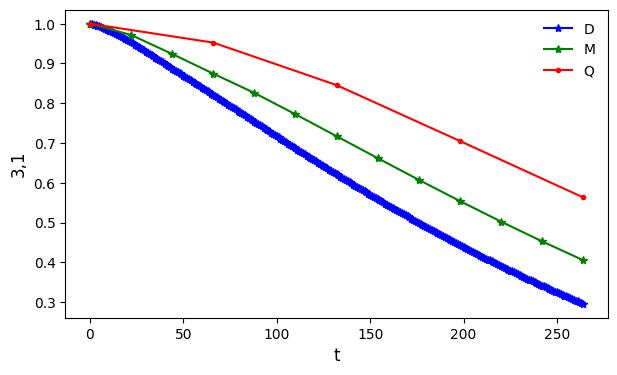

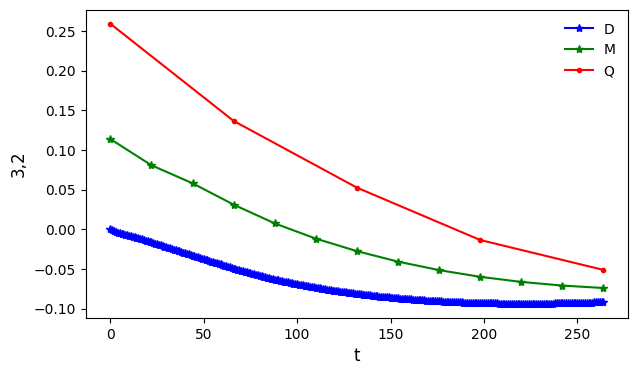

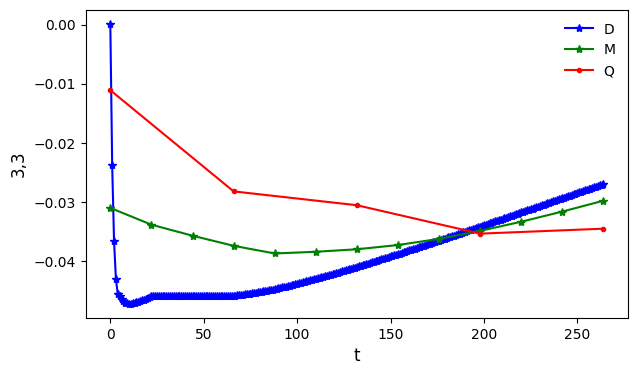

In [29]:
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(xs[:265][np.isfinite(irf0_d)], irf0_d[np.isfinite(irf0_d)], color = 'b', marker = '*', linestyle='-', label = 'D')
ax.plot(xs[:265][np.isfinite(irf0_m)], irf0_m[np.isfinite(irf0_m)], color = 'g',  marker = '*', linestyle='-', label = 'M')
ax.plot(xs[:temp_aggr][np.isfinite(irf0_q)], irf0_q[np.isfinite(irf0_q)], color = 'r', marker = '.', linestyle='-', label = 'Q')
plt.xlabel('t', fontsize=12)
plt.ylabel('3,1', fontsize=12)
ax.legend(frameon = False)
plt.show()


fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(xs[:265][np.isfinite(irf1_d)], irf1_d[np.isfinite(irf1_d)], color = 'b', marker = '*', linestyle='-', label = 'D')
ax.plot(xs[:265][np.isfinite(irf1_m)], irf1_m[np.isfinite(irf1_m)], color = 'g',  marker = '*', linestyle='-', label = 'M')
ax.plot(xs[:temp_aggr][np.isfinite(irf1_q)], irf1_q[np.isfinite(irf1_q)], color = 'r', marker = '.', linestyle='-', label = 'Q')
plt.xlabel('t', fontsize=12)
plt.ylabel('3,2', fontsize=12)
ax.legend(frameon = False)
plt.show()


fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(xs[:265][np.isfinite(irf2_d)], irf2_d[np.isfinite(irf2_d)], color = 'b', marker = '*', linestyle='-', label = 'D')
ax.plot(xs[:265][np.isfinite(irf2_m)], irf2_m[np.isfinite(irf2_m)], color = 'g',  marker = '*', linestyle='-', label = 'M')
ax.plot(xs[:temp_aggr][np.isfinite(irf2_q)], irf2_q[np.isfinite(irf2_q)], color = 'r', marker = '.', linestyle='-', label = 'Q')
plt.xlabel('t', fontsize=12)
plt.ylabel('3,3', fontsize=12)
ax.legend(frameon = False)
plt.show()